# **Packet Classification**

Notebook perofmring classification of device packets using time from last packet data.

## i. Imports

In [1]:
import os
import gc
import sys
import csv
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from imblearn.over_sampling import RandomOverSampler

## **1. Setup**

In [2]:
# Directories
BASEDIR = os.getcwd()
DATADIR = os.path.join(BASEDIR, 'data')
FIGUREDIR = os.path.join(BASEDIR, 'figures')

# Devices
devices = {'ihealth_bpm': 0, 'viatom_wpo': 1, 'vivachek_bgm': 2}

# Colour palette
sns.set_palette('deep')

# GPU settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    gc.collect()
    torch.cuda.empty_cache()

# Training hyperparameters
N_EPOCHS = 30
BATCH_SIZE = 128
N_FEATURES = 1
N_LABELS = 3
LEARNING_RATE = 0.001

In [3]:
# Custom functions
def bold(string):
    """
    Make string bold.

    Args:
        string (str): String to be made bold.

    Returns:
        str: Bold string.

    Raises:
        TypeError: If the input is not a string.
    """
    # Check input type
    if not isinstance(string, str):
        raise TypeError("Input must be a string!")
    
    return "\033[1m" + string + "\033[0m"

def calculate_metrics(y_true, y_pred, model, return_cm=False):
    """
    Calculate performance metrics and 
    plot confusion matrix given predictions 
    and ground truth values.

    Args:
        y_true (np.array): Array of ground truth y values.
        y_pred (np.array): Array of y value predictions.
        model (str): Name of model that generated predictions.
        return_cm (Bool): Boolean determining if confusion matric data is returned.

    Returns:
        float: Total model accuracy.
        DataFrame: DataFrame of groupwise performance metrics.
        DataFrame: Confusion matrix data (optional).
    """
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in devices],
                         columns = [c for c in devices])
    plt.figure(figsize = (12,7))
    plt.title(f'Confusion Matrix between Devices for {model} Model')
    sns.heatmap(df_cm, annot=True)
    plt.show()

    # Calculate performance metrics
    accuracy = 100 * np.sum(y_pred == y_true) / len(y_true)
    precision = np.round(precision_score(y_true, y_pred, average=None), 2)
    recall = np.round(recall_score(y_true, y_pred, average=None), 2)
    f1 = np.round(f1_score(y_true, y_pred, average=None), 2)

    # Create perfromance table
    res_df = pd.DataFrame([precision, recall, f1],
                           columns=devices.keys(),
                           index=['Precision', 'Recall', 'F1 Score'])

    # Return
    if return_cm:
        return accuracy, res_df, df_cm 
    else:
        return accuracy, res_df

## **2. Load data**

### 2.1 Load data from CSV

In [4]:
# CSV file into pandas
interpacket_csv = os.path.join(DATADIR, 'inter_packet_timings.csv')
data_df = pd.read_csv(interpacket_csv)

### 2.2 Prepare data for model training

In [5]:
class CustomDataset(Dataset):
    """
    Custom PyTorch Dataset 
    for time data.

    Attributes:
        data_array (array): NumPy array of data.
    """

    def __init__(self, data_array):
        self.data_array = data_array

    def __len__(self):
        return len(self.data_array)
    
    def __getitem__(self, idx):
        # Convert item to tensor
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Obtain sample and subject
        sample = self.data_array[idx]
        sample = torch.Tensor(sample)
        label = sample[-1]
        sample = sample[:-1]
        sample = torch.Tensor(sample)

        # Obtain label and encode
        label = onehot_encoder.transform([[label]])[0]

        return sample, label

In [6]:
# Split into training and test
[train_data, test_data] = train_test_split(data_df, random_state=1)

# Replace devices with numeric mapping
train_data.replace({'Device': devices}, inplace=True)
test_data.replace({'Device': devices}, inplace=True)

# Normalise data
train_temp_columns = train_data.iloc[:, -1]
test_temp_columns = test_data.iloc[:, -1]
train_data_norm = train_data.iloc[:, 0]
test_data_norm = test_data.iloc[:, 0]
train_data_norm = (train_data_norm-train_data_norm.mean())/train_data_norm.std()
test_data_norm = (test_data_norm-test_data_norm.mean())/test_data_norm.std()
train_data_norm = pd.concat([train_data_norm, train_temp_columns], axis=1)
test_data_norm = pd.concat([test_data_norm, test_temp_columns], axis=1)

In [7]:
# Check balance within the training dataset
counts = train_data_norm['Device'].value_counts()
for d, v in devices.items():
    print(f'Training samples from {d} - {counts[v]}')
print('')

# Balance data using over sampling
over_sampler = RandomOverSampler(random_state=1)
X_res, y_res = over_sampler.fit_resample(train_data_norm['Interpacket Timing'].values.reshape(-1, 1),
                                         train_data_norm['Device'].values)
train_data_norm_balanced = pd.DataFrame({'Interpacket Timing': np.squeeze(X_res),
                                         'Device': y_res})
    
# Check balance within the oversampled training dataset
counts = train_data_norm_balanced['Device'].value_counts()
for d, v in devices.items():
    print(f'Training samples from {d} after oversampling - {counts[v]}')
print('')

Training samples from ihealth_bpm - 5462
Training samples from viatom_wpo - 267
Training samples from vivachek_bgm - 4400

Training samples from ihealth_bpm after oversampling - 5462
Training samples from viatom_wpo after oversampling - 5462
Training samples from vivachek_bgm after oversampling - 5462



In [8]:
# Fit onehot encoder
onehot_encoder = OneHotEncoder(sparse_output=False)
train_labels = train_data_norm_balanced['Device'].values
train_labels = train_labels.reshape(len(train_labels), 1)
onehot_encoder.fit(train_labels)

# Print some statistics
print(f'Training data points: {train_data_norm_balanced.shape[0]}')
print(f'Test data points: {test_data_norm.shape[0]}')

Training data points: 16386
Test data points: 3377


In [9]:
# Create Datasets
train_dataset = CustomDataset(train_data_norm_balanced.to_numpy())
test_dataset = CustomDataset(test_data_norm.to_numpy())

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=0)

## **3. Logistic regression**

### 3.1 Define model

In [10]:
# Logisitc regression model
class LogisticRegression(nn.Module):
    def __init__(self, in_features, out_labels):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(in_features, out_labels)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [11]:
# Initiliase model
DeviceClassifier = LogisticRegression(in_features=N_FEATURES, out_labels=N_LABELS).to(device)
params = sum(p.numel() for p in DeviceClassifier.parameters() if p.requires_grad)
print("Total number of parameters for the classifier: {}\n".format(params))
print("Classifier architecture:")
print(DeviceClassifier)

# Optimiser and loss
optimizer = torch.optim.Adam(DeviceClassifier.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Total number of parameters for the classifier: 6

Classifier architecture:
LogisticRegression(
  (linear): Linear(in_features=1, out_features=3, bias=True)
)


### 3.2 Train model

In [12]:
# Initialise loss dictionary
total_loss = []

# Begin training
print('Beginning training...\n')
DeviceClassifier.train()

# Loop over epochs
for epoch in range(N_EPOCHS):
    # Running loss containers
    running_loss = 0.0

    # Loop over batches
    with tqdm(train_dataloader, unit="batch") as tepoch: 
        for batch_idx, (data, label) in enumerate(tepoch):

          # Batch tensor and add channel dimension
          batch_tensor = data.to(device)
          label = label.to(device)
          batch_tensor = batch_tensor[:, None, :]

          # Compute reconstructions
          results = DeviceClassifier(batch_tensor)
          results = results.squeeze()
          
          # Loss
          loss = criterion(results, label)

          # Backpropagation based on the loss
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Update loss
          running_loss += loss.item()

          # Log
          if batch_idx % 20 == 0:
            tepoch.set_description(f"Epoch {epoch+1}")
            tepoch.set_postfix(loss=loss.item())

        # Average epoch loss
        total_loss.append(running_loss/batch_idx+1)

Beginning training...



  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

  0%|          | 0/129 [00:00<?, ?batch/s]

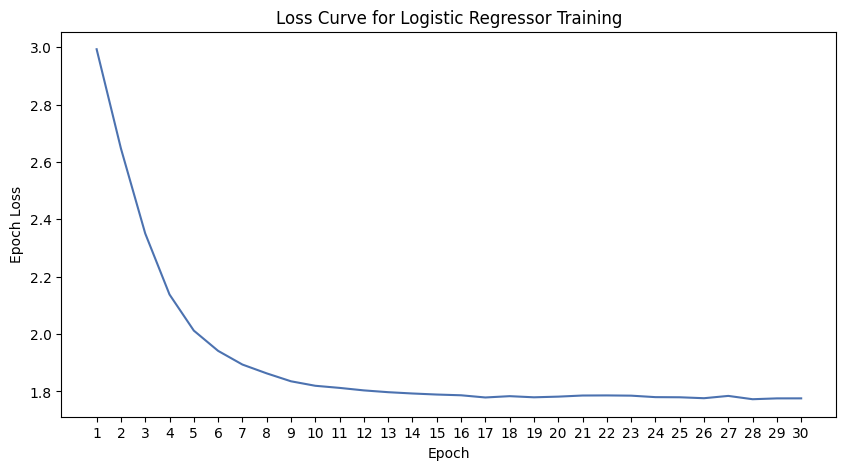

In [13]:
# PLot loss graph
plt.figure(figsize=(10,5))
x_ticks = list(range(1, len(total_loss)+1))
plt.plot(x_ticks, total_loss)
plt.ylabel('Epoch Loss')
plt.xlabel('Epoch')
plt.xticks(x_ticks)
plt.title('Loss Curve for Logistic Regressor Training')
plt.show()

### 3.3 Evaluate model

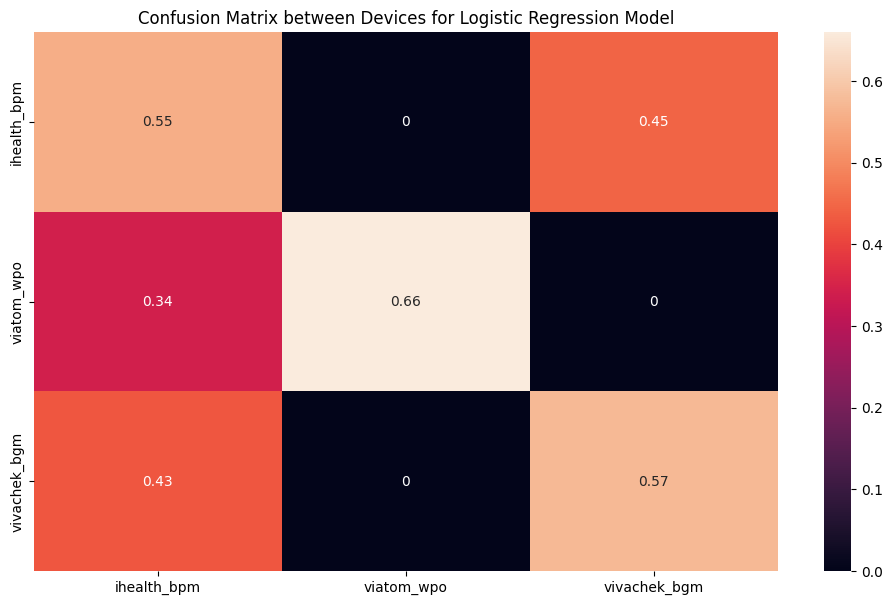

Performance Metrics for Logistic Regression Model:


,ihealth_bpm,viatom_wpo,vivachek_bgm
Precision,0.61,1.00,0.50
Recall,0.55,0.66,0.57
F1 Score,0.58,0.80,0.54


Logistic Regression Model accuracy on test set: 56.56%


In [14]:
# Containers for predictions
log_y_pred = []
y_true = []

# Put model in evaluation mode
DeviceClassifier.eval()
torch.no_grad()

# Loop over test batches
for data, labels in test_dataloader:
    # Batch tensor and add channel dimension
    batch_tensor = data.to(device)
    label = label.to(device)
    batch_tensor = batch_tensor[:, None, :]

    # Obtain model predictions
    results = DeviceClassifier(batch_tensor)
    results = results.squeeze()

    # Save predictions
    output = (torch.max(torch.exp(results), 1)[1]).data.cpu().numpy()
    log_y_pred.extend(output)

    # Unencode labels and save
    labels = onehot_encoder.inverse_transform(labels.cpu().numpy())
    labels = np.array([x[0] for x in labels])
    y_true.extend(labels)

# Calculate performance metrics
log_y_pred = np.array(log_y_pred)
y_true = np.array(y_true)
accuracy, performance_df = calculate_metrics(y_true, log_y_pred, model='Logistic Regression')
print('Performance Metrics for Logistic Regression Model:')
display(performance_df)
print(f'Logistic Regression Model accuracy on test set: {accuracy:.2f}%')

## **4. Support Vector Machine (SVM)**

### 3.1 Define and fit model

In [15]:
# Create data arrays
X_train = train_data_norm_balanced['Interpacket Timing'].values
X_test = test_data_norm['Interpacket Timing'].values
y_train = train_data_norm_balanced['Device'].values
y_test = test_data_norm['Device'].values

# Create an SVM classifier
SVMClassifier = svm.SVC(kernel='linear', C=1)

# Train the classifier on the training data
SVMClassifier.fit(X_train.reshape(-1, 1), y_train)

SVC(C=1, kernel='linear')

### 3.2 Evaluate model

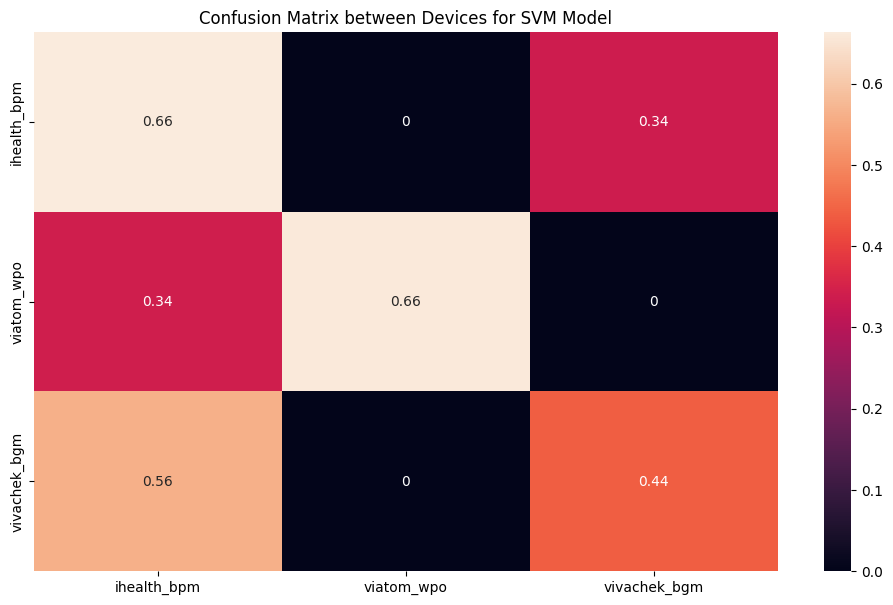

Performance Metrics for SVM Model:


,ihealth_bpm,viatom_wpo,vivachek_bgm
Precision,0.59,1.00,0.51
Recall,0.66,0.66,0.44
F1 Score,0.63,0.80,0.47


SVM Model accuracy on test set: 56.80%


In [16]:
# Make predictions on the test set
svm_y_pred = SVMClassifier.predict(X_test.reshape(-1, 1))

# Calculate performance metrics
svm_y_pred = SVMClassifier.predict(X_test.reshape(-1, 1))
y_true = y_test
accuracy, performance_df = calculate_metrics(y_true, svm_y_pred, model='SVM')
print('Performance Metrics for SVM Model:')
display(performance_df)
print(f'SVM Model accuracy on test set: {accuracy:.2f}%')